### Regime Identification in Multivariate Time-series

In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
import regimes
import numpy as np
import pandas as pd
import seaborn as sns
from clasp import ClaSP
from scipy import stats
from spdms import getSPDMs
from scipy.stats import norm
from datetime import datetime
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

np.random.seed(1)

In [10]:
# Normalization (Standard)
def normalize(data, type='minmax'):

    if type=='std':
        return (np.array(data) - np.mean(data))/np.std(data)
        
    elif type=='minmax':
        return (np.array(data) - np.min(data))/(np.max(data) - np.min(data))

In [11]:
# Function to trim time part from date string and use month names abbreviation
def trim_time_and_format(date_string):
    datetime_object = datetime.strptime(date_string, "%Y-%m-%d %H:%M:%S")
    return datetime_object #.strftime("%Y %b")

In [12]:
# Load data
file_path = r'../datasets/ecg/ECG200.txt'  # Replace with the actual file path
data = read_file(file_path)
if len(data.columns)==1:
    data = regimes.shift_and_fill_mean(data, 3)
data.head()

,col1,col2
0,-0.360730,1.965973
1,-0.901824,0.145364
2,-1.223426,-0.268573
3,-1.428917,-0.360730
4,-1.663475,-0.901824


In [8]:
# Apply the function to the entire column
time_column_exist, col_name = regimes.find_time_related_columns(data)
print(time_column_exist, col_name)
if time_column_exist:
    data['Date'] = data['Date'].apply(trim_time_and_format)

TypeError: argument of type 'method' is not iterable

In [35]:
data['Date'][2222]

Timestamp('2012-09-01 14:00:00')

In [36]:
data.set_index('Date', inplace=True)
data.head()

,Hs (m),SLP (mbar),W (km/h)
Date,,,
2012-06-01 00:00:00,0.8437,1018.4,16.92
2012-06-01 01:00:00,0.8644,1019.0,16.20
2012-06-01 02:00:00,0.8607,1018.9,16.92
2012-06-01 03:00:00,0.8376,1018.6,15.48
2012-06-01 04:00:00,0.8353,1018.1,16.92


In [37]:
data.index[2222]

Timestamp('2012-09-01 14:00:00')

In [38]:
# start, end = '2014-11-01', '2016-12-30'

# Appy mask get a segment from time series
# mask = (data['DateTime'] > '2014-11-01') & (data['DateTime'] <= '2015-12-28')
# data = data.loc[mask]

# data = data.fillna(method='pad')
# data = data.set_index('DateTime')
# data = data[start: end]
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4393 entries, 2012-06-01 00:00:00 to 2012-12-01 00:00:00
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Hs (m)      4387 non-null   float64
 1   SLP (mbar)  4391 non-null   float64
 2   W (km/h)    4391 non-null   float64
dtypes: float64(3)
memory usage: 137.3 KB


In [39]:
data.isnull().sum()

Hs (m)        6
SLP (mbar)    2
W (km/h)      2
dtype: int64

In [40]:
# Loop through columns and fill NaN values with mean
for column in data.columns:
    if data[column].isnull().any():
        mean_value = data[column].mean()
        data[column].fillna(mean_value, inplace=True)

In [41]:
# data = data.dropna(how='any',axis=0) 
# data = data.drop(columns=['Date'])
columns = data.columns
data.isnull().sum()

Hs (m)        0
SLP (mbar)    0
W (km/h)      0
dtype: int64

In [42]:
data.head()

,Hs (m),SLP (mbar),W (km/h)
Date,,,
2012-06-01 00:00:00,0.8437,1018.4,16.92
2012-06-01 01:00:00,0.8644,1019.0,16.20
2012-06-01 02:00:00,0.8607,1018.9,16.92
2012-06-01 03:00:00,0.8376,1018.6,15.48
2012-06-01 04:00:00,0.8353,1018.1,16.92


In [43]:
data = data.apply(normalize)

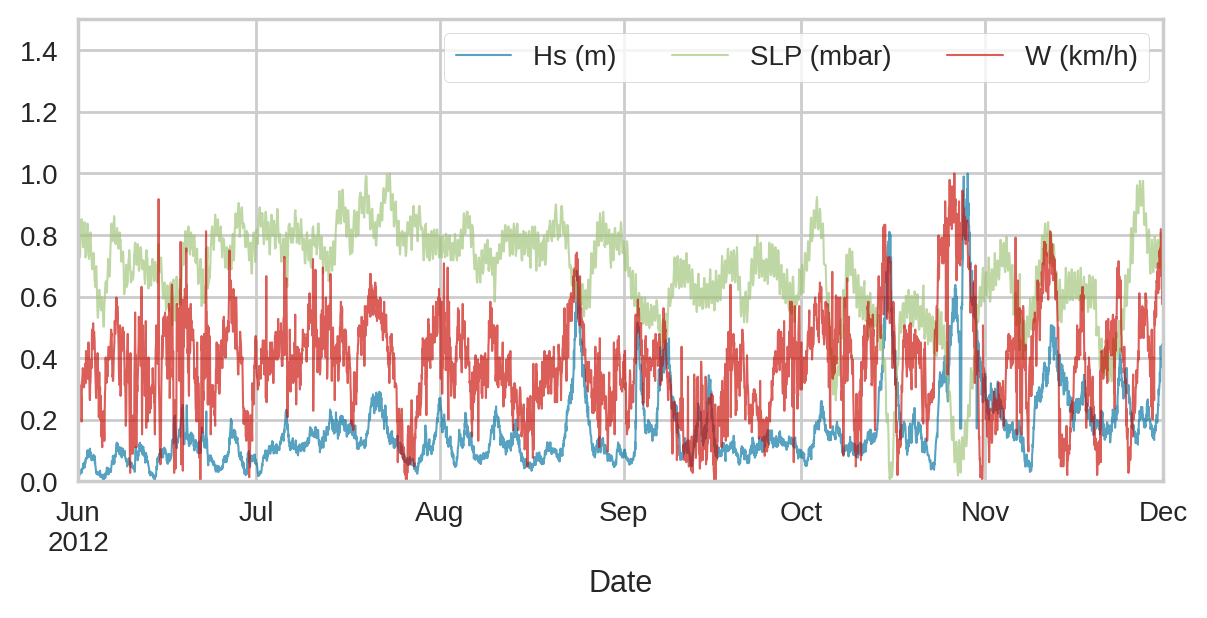

In [44]:
# toplot = [ 'rain', 'snow_load', 'pressure_outside','gw_mb', 'gw_sg', 'gw_west', 'strain_ns_corrected']
# toplot = ['gw_mb', 'gw_sg', 'temperature_outside', 'strain_ew_corrected', 'strain_ns_corrected']
toplot = ['Z1', 'Z2','Z3']
toplot = columns

for i in toplot:
    data[i].plot(use_index=True, figsize=(7, 3), linewidth=0.75, alpha=0.66)
    plt.legend(toplot, frameon=True, ncol=3)

plt.ylim(0, 1.5)
# plt.gcf().autofmt_xdate()
# plt.legend(['Temperature', 'Ground Water', 'Strain_EW', 'Strain_NS'])
# plt.legend(['$Z_{1}$', '$Z_{2}$', '$Z_{3}$'])
# plt.savefig("synreg25Apr.png")
plt.show()

In [56]:
# Desired number of clusters. Set k=None to let the algorithm aumotically find opitmal k.
k = 2        # k=None

# Sliding window size
winsize = 140 # 155

# distance metrics
metricE = 'Euclidean'
metricR = 'Riemannian'

# Specify reduced dimension size, default is dim='full' for no dimension reduction.
dim = 'fULl' 

# Retrieve regimes with their corresponding indices
clusters, cluster_idx, *_ = regimes.get_regimes(data, winsize, metricE, k, dim)

Regimes:(0, 0) (0, 140) (0, 280) (0, 420) (0, 560) (0, 700) (0, 840) (0, 980) (0, 1120) (0, 1260) (0, 1400) (0, 1540) (0, 1680) (0, 1820) (1, 1960) (0, 2100) (0, 2240) (0, 2380) (0, 2520) (0, 2660) (0, 2800) (0, 2940) (0, 3080) (1, 3220) (0, 3360) (1, 3500) (0, 3640) (0, 3780) (0, 3920) (0, 4060) (0, 4200)


In [ ]:
clusters_extended = []

for i in range(len(clusters)):

    val = clusters[i]
    for j in range(winsize):
        clusters_extended.append(val)
        
print(len(clusters_extended), data.shape)

4340 (4393, 3)


In [ ]:
datanew = data.iloc[:len(clusters_extended), :].copy()
datanew['Clusters'] = clusters_extended

<Figure size 3000x800 with 0 Axes>

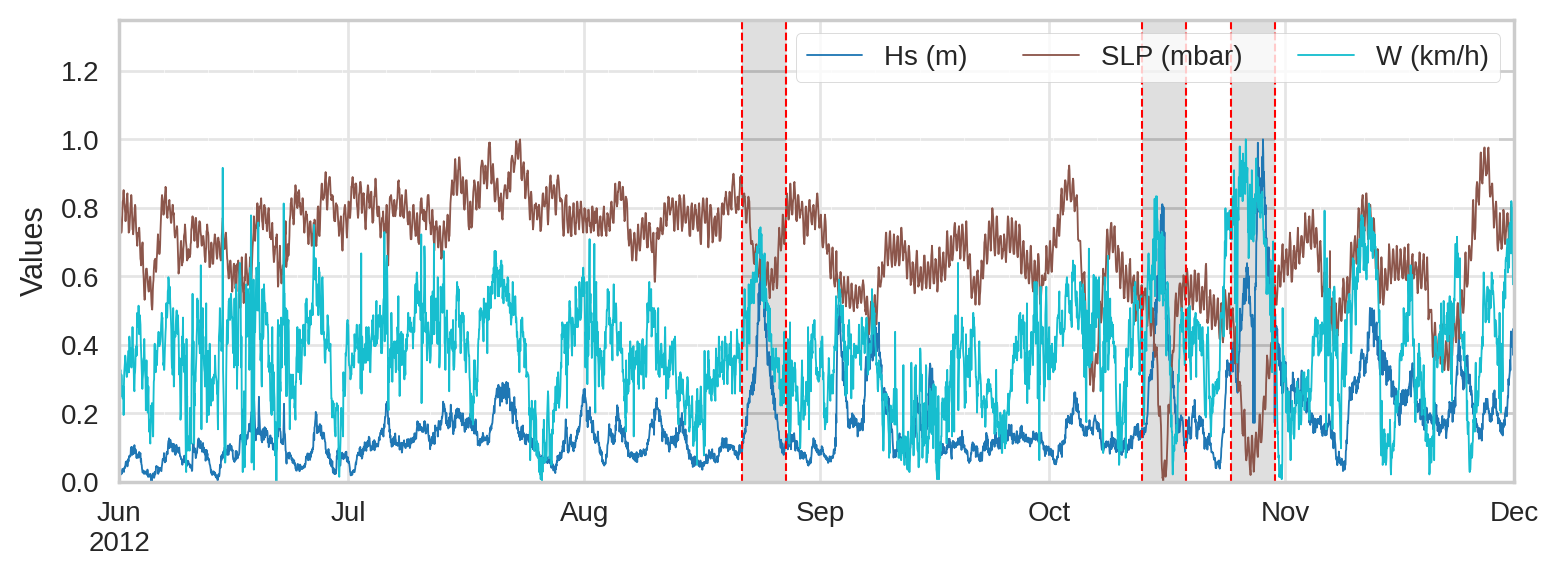

In [57]:
var_to_plot = columns
regimes.visualize_regimes(data, var_to_plot, clusters, cluster_idx, winsize, dtype='real')

In [58]:
import clasp